In [3]:
!wget --no-check-certificate \
https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rp73yg93n8-1.zip -O /tmp/dataset.zip

--2020-08-30 10:20:17--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rp73yg93n8-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.24.120
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.24.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418811602 (399M) [application/octet-stream]
Saving to: ‘/tmp/dataset.zip’

/tmp/dataset.zip    100%[===================>] 399.41M  10.7MB/s    in 37s     

2020-08-30 10:20:55 (10.8 MB/s) - ‘/tmp/dataset.zip’ saved [418811602/418811602]



In [9]:
from zipfile import ZipFile
import os

local_zip = '/tmp/dataset.zip'

zip_file = ZipFile(local_zip, 'r')
zip_file.extractall('/tmp')
zip_file.close()

extracted_zip = '/tmp/fruits-360_dataset.zip'

zip_file = ZipFile(extracted_zip, 'r')
zip_file.extractall('/tmp')
zip_file.close()

In [10]:
import pandas as pd

data_path = '/tmp/fruits-360/Training'

train_path = []
train_label = []
for label in os.listdir(data_path):
    for item in os.listdir(os.path.join(data_path, label)):
        train_path.append(data_path + '/' + label + '/' + item)
        train_label.append(label)

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_path, train_label, test_size=0.2, random_state=1)

training_set = pd.DataFrame({'y': y_train, 'X': X_train})
test_set = pd.DataFrame({'y': y_test, 'X': X_test})

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [22]:
train_generator = train_datagen.flow_from_dataframe(
    training_set,
    x_col='X',
    y_col='y',
    target_size=(50,50),
    batch_size=4,
    class_mode='sparse'
)

validation_generator = test_datagen.flow_from_dataframe(
    test_set,
    x_col='X',
    y_col='y',
    target_size=(50,50),
    batch_size=4,
    class_mode='sparse'
)

Found 33057 validated image filenames belonging to 81 classes.
Found 8265 validated image filenames belonging to 81 classes.


In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.losses import sparse_categorical_crossentropy

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(50, 50, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(81, activation='softmax')
])

model.compile(loss=sparse_categorical_crossentropy,
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [37]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92):
      print("\nAkurasi telah mencapai >92%!")
      self.model.stop_training = True

callbacks = myCallback()

In [38]:
history = model.fit(
            train_generator,
            epochs=20,
            steps_per_epoch=500,
            validation_data=validation_generator,
            validation_steps=100,
            verbose=2,
            callbacks=[callbacks])

Epoch 1/20
500/500 - 18s - loss: 3.3073 - accuracy: 0.1510 - val_loss: 2.1265 - val_accuracy: 0.3625
Epoch 2/20
500/500 - 18s - loss: 1.6475 - accuracy: 0.4780 - val_loss: 1.1141 - val_accuracy: 0.6275
Epoch 3/20
500/500 - 19s - loss: 0.9773 - accuracy: 0.6765 - val_loss: 0.7496 - val_accuracy: 0.7450
Epoch 4/20
500/500 - 18s - loss: 0.7001 - accuracy: 0.7710 - val_loss: 0.8761 - val_accuracy: 0.6850
Epoch 5/20
500/500 - 18s - loss: 0.5096 - accuracy: 0.8220 - val_loss: 0.4761 - val_accuracy: 0.8500
Epoch 6/20
500/500 - 18s - loss: 0.4070 - accuracy: 0.8615 - val_loss: 0.2644 - val_accuracy: 0.9225
Epoch 7/20
500/500 - 18s - loss: 0.3804 - accuracy: 0.8810 - val_loss: 0.2359 - val_accuracy: 0.9300
Epoch 8/20
500/500 - 18s - loss: 0.3361 - accuracy: 0.8855 - val_loss: 0.3848 - val_accuracy: 0.8675
Epoch 9/20
500/500 - 18s - loss: 0.2817 - accuracy: 0.9070 - val_loss: 0.4089 - val_accuracy: 0.8500
Epoch 10/20
500/500 - 18s - loss: 0.3395 - accuracy: 0.8905 - val_loss: 0.1990 - val_accura

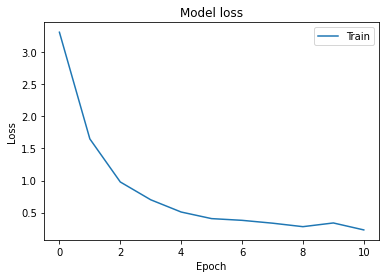

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

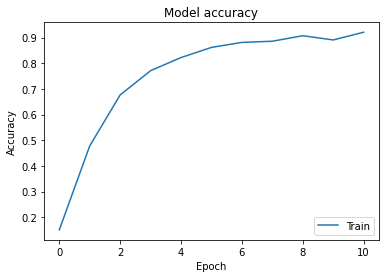

In [40]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

In [41]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp8ks7ua1f/assets


INFO:tensorflow:Assets written to: /tmp/tmp8ks7ua1f/assets


In [42]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)